# Prediction <img align="right" src="../figs/DE_Africa_Logo_Stacked_RGB_small.jpg">

## Description

Using the model we created in the `3_Train_fit_evaluate_classifier.ipynb`, this notebook will make predictions on new data to generate a cropland mask for Eastern Africa. The notebook will ceate both pixel-wise classifications and classification probabilities. Results are saved to disk as Cloud-Optimised-Geotiffs.

1. Open and inspect the shapefile which delineates the extent we're classifying
2. Import the model
3. Make predictions on new data loaded through the ODC.  The pixel classification will also undergo a post-processing step where steep slopes and water are masked using a SRTM derivative and WOfS, respectively. Pixels labelled as crop above 3600 metres ASL are also masked. 

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [ ]:
# !pip install -e ../../production/dea_ml
# !pip install git+https://github.com/digitalearthafrica/deafrica-sandbox-notebooks.git@minty-fresh-sandbox#subdirectory=Tools

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
from joblib import load
from odc.algo import xr_reproject
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from datacube.testutils.io import rio_slurp_xarray

from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.classification import predict_xr, HiddenPrints
from deafrica_tools.plotting import map_shapefile
from deafrica_tools.spatial import xr_rasterize

from dea_ml.core.africa_geobox import AfricaGeobox

#import out feature layer function for prediction
from feature_layer_functions import gm_mads_two_seasons_prediction
from post_processing import post_processing


### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:40353 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


## Analysis parameters

* `model_path`: The path to the location where the model exported from the previous notebook is stored
* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `test_shapefile`: A shapefile containing polygons that represent regions where you want to test your model. The shapefile should have a unique identifier as this will be used to export classification results to disk as geotiffs. Alternatively, this could be a shapefile that defines the extent of the entire AOI you want to classify.
* `results`: A folder location to store the classified geotiffs 

In [3]:
model_path = 'results/gm_mads_two_seasons_ml_model_20210427.joblib'

training_data = "results/training_data/gm_mads_two_seasons_training_data_20210427.txt"

test_shapefile = 'data/s2_tiles_eastern_aez.geojson'

results = 'results/classifications/'

output_suffix = '20210427'

dask_chunks = {'x':10000, 'y':10000}

### Open and inspect test_shapefile

In [4]:
gdf = gpd.read_file(test_shapefile)

In [5]:
# gdf.head()
# map_shapefile(gdf, attribute='title')

## Open the model

The code below will also re-open the training data we exported from `3_Train_fit_evaluate_classifier.ipynb`

and wwe import the column names of the feature layers

In [6]:
model = load(model_path)

In [7]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:][1:]

## Making a prediction


### Loop through test tiles and predict (with post-processing)

For every tile we list in the `test_shapefile`, we calculate the feature layers, and then use the DE Africa function `predict_xr` to classify the data.

The `feature_layer_functions.gm_mads_two_seasons_prediction` and `post_processing.post_processing` functions are doing most of the heavy-lifting here

The results are exported to file as Cloud-Optimised Geotiffs.

In [8]:
#make a folder to store results in if one doesn't already exist
if not os.path.exists(results+output_suffix):
        os.mkdir(results+output_suffix)

In [9]:
%%time
#get affine of all tiles as geobox object
geobox_dict = AfricaGeobox(resolution=20)#.geobox_dict

i=1
for index, row in gdf[217:218].iterrows():
    
    #grab x,y id from the geopan
    x,y = gdf.loc[index]['title'].split(",")
    x, y = int(x)+181, int(y)+77
    
    print('working on tile: '+str(x)+','+str(y),str(i)+"/"+str(len(gdf)),end='\r')

    #get affine of single tile as geobox object
    geobox = geobox_dict[(x,y)]
    
    #run feature layer function
    data = gm_mads_two_seasons_prediction(geobox, dask_chunks)
    data = data[column_names]
    
   #predict using the imported model
    with HiddenPrints():
        predicted = predict_xr(model,
                           data,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True
                          ).compute()
        
    #-------Post-processsing ------------------------------    
    predict, proba, mode = post_processing(predicted)
#     #----export classifications to disk-----------------------
# #     write_cog(predict,
# #               results+output_suffix+'/Eastern_'+str(x)+'_'+str(y)+'_prediction_pixel_'+output_suffix+'.tif',
# #               overwrite=True)
#     break
#     i+=1


  image segmentation... 1/390
  calculating mode...
  masking with AEZ,WDPA,WOfS,slope & elevation
CPU times: user 4min 3s, sys: 27.5 s, total: 4min 31s
Wall time: 8min 13s


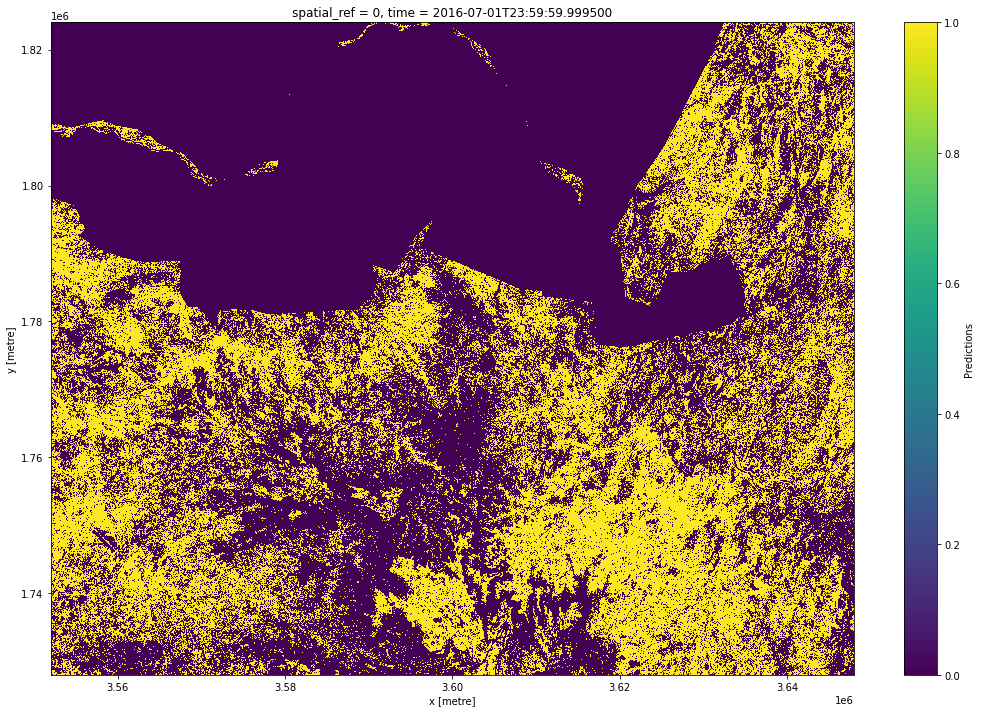

In [10]:
predict.plot(size=12);

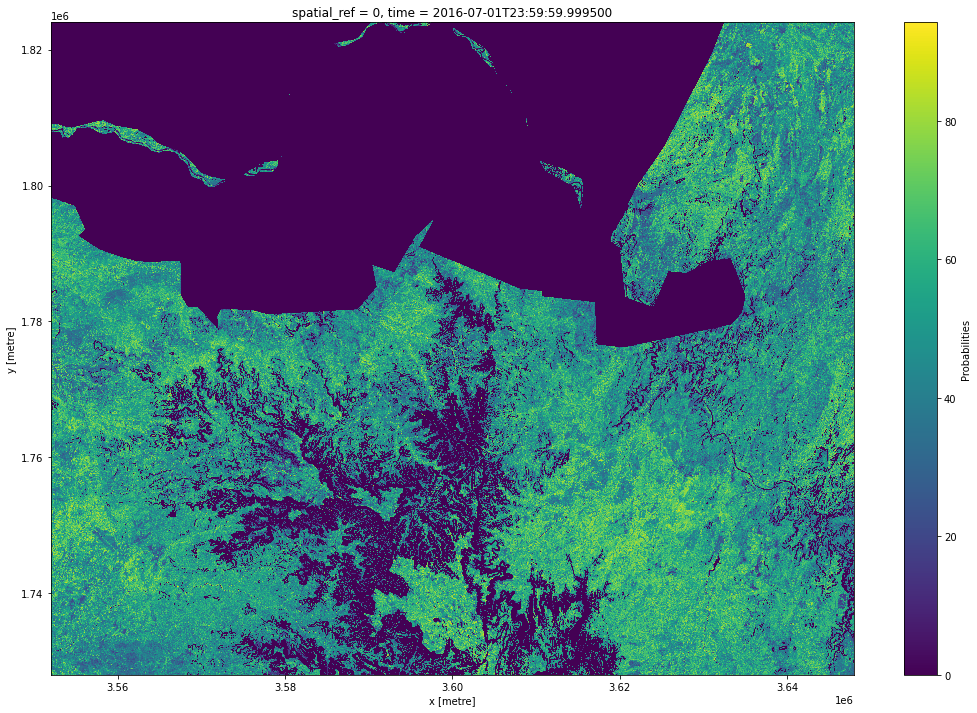

In [11]:
proba.plot(size=12);

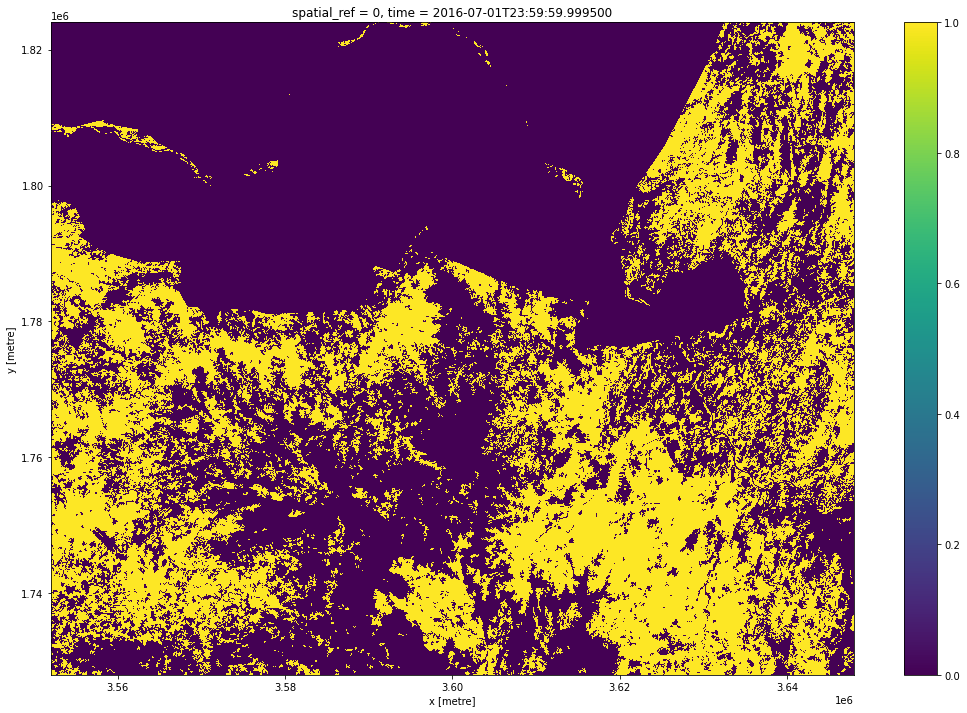

In [12]:
mode.plot(size=12);

## Next steps

To continue working through the notebooks in this `Eastern Africa Cropland Mask` workflow, go to the next notebook `5_Object-based_filtering.ipynb`.

1. [Extracting_training_data](1_Extracting_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. [Train_fit_evaluate_classifier](3_Train_fit_evaluate_classifier.ipynb)
4. **Predict (this notebook)**
5. [Object-based_filtering](5_Object-based_filtering.ipynb)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Dec 2020
